# Global-Search, Surrogate-Based Optimization

An alternative approach to direct-search algorithms are algorithms that rely on collecting data from the entire space, and fitting models for the entire search region. 

## Sampling Methods:
There are several sampling strategies that are used to collect data within a space. 

**Question:** What do you think makes a good sampling design? Think of the 2D space shown below where x1 and x2 are normalized between 0-1. How many samples would you collect and where would you place them? Why?

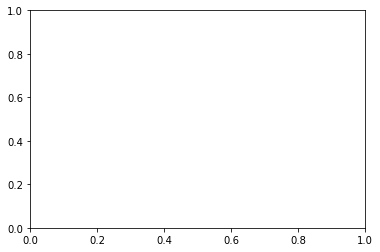

In [1]:
%matplotlib inline
from pylab import *
from matplotlib.patches import Rectangle
currentAxis = plt.gca()

- How many points?
  - It depends on how complex the output is!
  - Limitations in sampling.
- Where would you place them?
  - At corner points and then, in middle?
  - If more..?
- Are there other considerations to take into account?
  - The type of model you want to fit, should affect the data you collect!

### Experimental Design of Experiments:

**How many of you have done experimental research?**<br>

"**Design Of Experiments**" refers to techniques that aim to tell us where to collect data to study the effects of various inputs on the outputs of a system. Typically, the data is used to "fit" a simplified statistical model that "maps" the inputs to the output. <br>

**Key Concepts I want you to get from the next few lectures:**

1. The design of experiments (DoE) we select to use, is *linked with the type of function* we want to fit to the data. 
<br>

2. *"Experimental DoE"* and *"Computational DoE"* often refer to different types of methods. What are the differences?
<br>

3. When using data, one must know where it came from. Was it *"designed"* or is it a *historical data* set collected as a system is operated? What we can do with these two different forms of data is significantly different.
<br>

4. One other categorization of data has to do with the inputs. Do we know the *independent inputs* that should be used to predict an output? OR is the data high-dimensional and we are not sure whether all inputs are important, or whether the inputs are "correlated" or *"dependent"*?
<br>

5. Is the data-generating system (experiment or simulation) deterministic or stochastic?
 - *Deterministic*: For a fixed input, the system will give us the same output every time we call it.
 - *Stochastic*: For a fixed input, the system will give us a slightly differetn output every time we call it.


#### Experimental DoE, with known independent inputs:

 - How do we know which inputs are important for a given system?
   - **Select for inputs we can control (those are likely to be independent)**, 
   - **Select inputs we know from physics/chemistry/thermo/kinetics affect an output**, 
   - **Get feedback from experts**.

#### How do these designs scale?

 - In 2 dimensions, if I want to collect a factorial design with 2 levels for each variable, I have $2^2=4$ points.
 - In 3 dimensions, if I want to collect a factorial design with 2 levels for each variable, I have $2^3=8$ points.
 
 ... **This number can explode!**
 

#### "CURSE OF DIMENSIONALITY":

<img src="cod.png" width="1000" />


#### How are the points we collected linked to the models we can "fit" as surrogates?
**Example:**
Imagine you are in the lab, and your colleague has designed an experiment of a *Pressure-Swing Adsorption* process. The goal is to fit a function to explain how adsorption time and and desorption time (both design parameters or else inputs) affect the purity of the process output stream (output). You know that both adsorption time ($x_1$) and desorption time ($x_2$) can range between 50-250 seconds.

Your colleague has collected the following data:
<img src="data1.jpg" width="300" />

Using this data, your colleague wants your help to fit a surrogate model that will be able to predict the purity as a function of the two inputs. Below is the code they used for that:

In [2]:
from pyomo.environ import *
model = ConcreteModel()

#Define Data:
model.n = [1,2] #dimension
model.s = [1,2,3,4] #sample
model.yact = {1:93.2, 2:94.7,3:97.3,4:98.7} 
model.xs = {(1,1):25,(1,2):25,(2,1):250,(2,2):25,(3,1):25,(3,2):250,(4,1):250,(4,2):250} 

model.ypred = Var(model.s, within=NonNegativeReals) 
model.a = Var()
model.b = Var()
model.c = Var()
model.d = Var()
 

def con_rule(model,i): # postulated function is: y=a + b*x_1 + c*x_2 + d*x_1*x_2
    return (model.a+ sum(model.b*model.xs[i,1]+model.c*model.xs[i,2]+model.d*(model.xs[i,1]*model.xs[i,2])) - model.ypred[i] == 0)


#Instead of defining the constraint as we did above, we now set it equal to the rule.
model.con = Constraint(model.s, rule=con_rule)

def obj_rule(model): 
    return sum((model.ypred[i]-model.yact[i])**2 for i in model.s)


#Instead of defining the objective as we did above, we now set it equal to the rule.
model.obj = Objective(rule=obj_rule) 

#same as above:
solver = SolverFactory('ipopt')
solver.solve(model)
model.pprint()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


2 Set Declarations
    con_index : Dim=0, Dimen=1, Size=4, Domain=None, Ordered=False, Bounds=(1, 4)
        [1, 2, 3, 4]
    ypred_index : Dim=0, Dimen=1, Size=4, Domain=None, Ordered=False, Bounds=(1, 4)
        [1, 2, 3, 4]

5 Var Declarations
    a : Size=1, Index=None
        Key  : Lower : Value             : Upper : Fixed : Stale : Domain
        None :  None : 92.57654320990324 :  None : False : False :  Reals
    b : Size=1, Index=None
        Key  : Lower : Value                 : Upper : Fixed : Stale : Domain
        None :  None : 0.0067160493827141485 :  None : False : False :  Reals
    c : Size=1, Index=None
        Key  : Lower : Value                : Upper : Fixed : Stale : Domain
        None :  None : 0.018271604938266576 :  None : False : False :  Reals
    d : Size=1, Index=None
        Key  : Lower : Value                   : Upper : Fixed : Stale : Domain
        None :  None : -1.9753086419740077e-06 :  None : False : False :  Reals
    ypred : Size=4, Index=y

**In class exercise: Take out a sheet of paper as you do in groups and write your thoughts about your colleague's model.**
 - Is it predictive? No!
 - Is this a good model? No!
 - What are your recommendations? Collect more data.

#### Validation
When collecting data, it is EXTREMELY important to validate. For the previous example, what happens if we try to validate our model with the following data:

<img src="data_2.png" width="500" />

**Notes:**
 - Why is this data useful?
   - Validation
   - Re-fitting nonlinear terms!
 - How would you use it?

**End of Notes:**

#### Computer DoE:

 - When we have a computer simulation, that we can use to freely generate data anywhere in the space, different types of designs are often used.
 - These designs aim to do two things:
     - Collect representative set of samples from entire region
     - Minimize sampling requirements
     - Allow for non-linear interactions to be captured.
     
#### Latin Hyperbube Sampling:
- Most popular technique for sampling using computer DOE!!!
- They can avoid the problem of the "Curse of Dimensionality"
- They have a randomness component in them, but they are better than completely random sampling.


To illustrate in two dimensions: suppose we have a system with two input variables ranging from 0 to 1, and we want to understand the effect they have on the response of the system. Further suppose that we're willing to run 30 experiments, and no more.

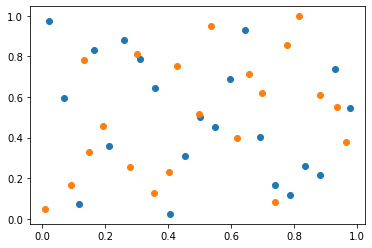

In [3]:
##BUILT-IN CODES TO GENERATE LHD DESIGNS:
from pyDOE import *
n = 2
samples = 21

#lhs(n, [samples, criterion, iterations])
d1 = lhs(n, samples, criterion='center')
d2 = lhs(n, samples, criterion='maximin')

scatter(d1[:,0],d1[:,1])
scatter(d2[:,0],d2[:,1])

# Surrogate-based Optimization

## Steps/Overview:

**There are few simple steps for using surrogates for optimization:**

There are **6 steps**:
1. Identify inputs & bounds
2. Collect initial data
3. Select surrogate type(s) and fit them
4. Validate surrogate fits
5. Optimize surrogates
6. Converge: Decide whether you are finished or whether you will do more iterations. 

### Step 1: Identify Inputs, Bounds

1. **Selecting inputs**: This is a straight-forward step, but very important. <br> If you don't pick the right inputs, or you pick too many correlated inputs, none of the next steps might work!. <br> Let's assume for now that we know the set of important degrees-of-freedom.

2. **Selecting Bounds**: Bounds are necessary for what we are about to do in the next steps. <br> Sometimes bounds are practically known (operating range of a process), but sometimes hard to decide on. <br> You have flexibility here. You can select an initial set of bounds and if your solutions are close to boundary, <br> you can expand and repeat all steps.


### Step 2: Collect INITIAL Data

As discussed in previous lecture, this is a very important step. You must:

1. **Collect enough initial data for the model you'll be fitting next**
2. **Collect enough initial data to model nonlinearity (if you don't absolutely know your system is linear).<br> This means that you need to have points that are not only changing one factor at a time!**
3. **Collect enough data to do some validation.**
4. **How large is your initial data set?**
     - Use Heuristic: *~10dimension*
     - Depends on how expensive your samples are
     - Depends on how nonlinear your system is
5. **Use the right Design of Experiments!**

### Step 3: Select type of surrogate and fit it

- Many options here!!! And more coming with all developments in **Machine Learning**.
- **Which one is the best???** Nobody knows! It depends on application and what you want to do with the model.
- In this class, we need to keep in mind that we want to use the models to optimize them. What does that mean?
- We need to maintain a balance between **accuracy** and **complexity**.
<br>
<br>
    1. **If a fitted model is very simple (i.e., linear), but not as accurate**: 
        - A standard algorithm can give you the global solution fast. But since the model is not accurate, <br> how useful is that global solution??        
    2. **If a fitted model is very nonconvex, but very accurate**: 
        - A standard algorithm can only guarantee to find a local solution fast.
        - A global optimization algorithm may give you a global solution but at high computational cost.
        - How useful is a local solution?
        - How useful is the global solution at high-cost vs. the time it would take to collect <br> many more samples in that same time?
   
<img src="Lecture18_1.png" width="1000" />

<img src="Lecture18_2.png" width="1000" />


#### Types of surrogates:
1. Linear
2. Quadratic
3. Polynomial
4. Generalized Linear Regression
5. Gaussian Process Models (Kriging)
6. Radial Basis Functions
7. High-dimensional Model Representations
8. Neural Networks
9. Support Vector Regression
10. Random Forests 
11. Others that I do not even know!

**What you need to ask before you use them FOR OPTIMIZATION:**

1. How 'flexible' is it, vs. how flexible I need it to be?

2. Can I optimize it (locally or globally)?

3. How 'expensive' is it to fit?

4. How 'expensive' is it to optimize?

5. How many parameters does it have? (also important for how many points you need to collect).


### Step 4: Validate surrogate

**Very Important!!!**

**Definitions: Training Data**
The data that is used to fit the model parameters.

**Definition: Validation or Test data**
The data that is used to validate the model. Cannot be the same as the training data.

Every time you fit a model, you need to validate it on data that was *unseen* by the model <br> when fitting the parameters.

#### CROSS VALIDATION:
Very important idea in regression and machine learning. The idea is, I sometimes cannot afford <br> to collect more points so what I do is I leave some of the points I have collected "out" and separate my sampling set to a <br> training and validation set.

**Steps:**
1. Collect $N$ points.
2. For k iterations do:
    - Randomly select $m<N$ points as Validation points, 
    - Use rest $N-m$ points to train the model.
    - Use trained model to predict $m$ Validation points. 
    - Calculate Error of Validation points.
3. Calculate Average Cross-Validation Error as the Average of all the k errors.

The Average Cross-Validation error is a good predictor of how good the model is.

**How do I split the data? What is $N$, what is $m$, how many $k$???**
 - Typically $m$ is a 5-20% of $N$
 
 - If you can afford to collect 5-20% more data at first, do it.
 
 - If you have no ability to collect more data, assess based on $N$, <br> how much you can afford to leave out, so your training set is a good enough number.
 
 - You can even do *Leave-One-Out* cross-validation, where every time you leave only 1 sample out.
 
 - $k$ is the number of iterations. Again that depends on the amount of data you have. <br> For leave-one-out, you can only do up to $k=N$ iterations.
 
**Example:**
 - In a 2D example, using heuristic $10n$, I collect $N=20$ points. I then fit the model $k=20$ times, <br> each time leaving one of the samples out for validation error.
 
 - In a 2D example, I collect: $N=20+5=25$ points. I then set $k=5$. For each $k$, <br> I randomly select $m=5$ samples as my validation set, use the 20 remaining for training. 
 

**Let's look at the example from last lecture:**
<img src="data_2.jpg" width="500" />

In [4]:
from pyomo.environ import *
model = ConcreteModel()

#Define Data:
model.n = [1,2] #dimension
model.s = [1,2,3,4,5,6,7,8,9] #sample
model.yact = {1:93.2, 2:94.7,3:97.3,4:98.7,5:96.6, 6:98.2,7:94.6,8:98.6,9:98.0} 
model.xs = {(1,1):25,(1,2):25,(2,1):250,(2,2):25,(3,1):25,(3,2):250,(4,1):250,(4,2):250,(5,1):25,(5,2):138,
            (6,1):250,(6,2):138,(7,1):138,(7,2):25,(8,1):138,(8,2):250,(9,1):138,(9,2):138} 

model.ypred = Var(model.s, within=NonNegativeReals) 
model.a = Var()
model.b = Var()
model.c = Var()
model.d = Var()

def con_rule(model,i): # postulated function is: y=a + b*x_1 + c*x_2 + d*x_1*x_2
    return (model.a+ model.b*model.xs[i,1]+model.c*model.xs[i,2]+model.d*(model.xs[i,1]*model.xs[i,2])) - model.ypred[i] == 0
model.con = Constraint(model.s, rule=con_rule) #Instead of defining the constraint as we did above, we now set it equal to the rule.

def obj_rule(model): 
    return sum((model.ypred[i]-model.yact[i])**2 for i in model.s)
model.obj = Objective(rule=obj_rule) #Instead of defining the objective as we did above, we now set it equal to the rule.

#same as above:
solver = SolverFactory('ipopt')
solver.solve(model)
model.a.pprint()
model.b.pprint()
model.c.pprint()
model.d.pprint()

def surr(x1,x2):
    return model.a+model.b*x1+model.c*x2+model.d*(x1*x2)

err = value(sum((model.yact[i]-model.ypred[i])**2 for i in model.s))

print(err)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


a : Size=1, Index=None
    Key  : Lower : Value             : Upper : Fixed : Stale : Domain
    None :  None : 93.22898646889051 :  None : False : False :  Reals
b : Size=1, Index=None
    Key  : Lower : Value                 : Upper : Fixed : Stale : Domain
    None :  None : 0.0069458688830371625 :  None : False : False :  Reals
c : Size=1, Index=None
    Key  : Lower : Value                : Upper : Fixed : Stale : Domain
    None :  None : 0.018215588917799355 :  None : False : False :  Reals
d : Size=1, Index=None
    Key  : Lower : Value                 : Upper : Fixed : Stale : Domain
    None :  None : -1.96943427598757e-06 :  None : False : False :  Reals
4.724209867048854


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


**How do we do cross-validation with this model?**
 - Algorithmically, we need to be efficient, can't write this model $k$ times and manually change set size!! (like below!)

In [2]:
from pyomo.environ import *
model = ConcreteModel()

#Define Data:
model.n = [1,2] #dimension
model.s = [1,2,3,4,5,6,7] # removed last two samples
model.v = [1,2] #validation set
model.yact = {1:93.2, 2:94.7,3:97.3,4:98.7,5:96.6, 6:98.2,7:94.6} 

model.xs = {(1,1):25,(1,2):25,(2,1):250,(2,2):25,(3,1):25,(3,2):250,(4,1):250,(4,2):250,(5,1):25,(5,2):138,
            (6,1):250,(6,2):138,(7,1):138,(7,2):25}

model.xv = {(1,1):138,(1,2):250,(2,1):138,(2,2):138}
model.yv = {1:98.6,2:98.0}

model.ypred = Var(model.s, within=NonNegativeReals) 
model.a = Var()
model.b = Var()
model.c = Var()
model.d = Var()

def con_rule(model,i): # postulated function is: y=a + b*x_1 + c*x_2 + d*x_1*x_2
    return (model.a+ model.b*model.xs[i,1]+model.c*model.xs[i,2]+model.d*(model.xs[i,1]*model.xs[i,2])) - model.ypred[i] == 0
model.con = Constraint(model.s, rule=con_rule) #Instead of defining the constraint as we did above, we now set it equal to the rule.

def obj_rule(model): 
    return sum((model.ypred[i]-model.yact[i])**2 for i in model.s)
model.obj = Objective(rule=obj_rule) #Instead of defining the objective as we did above, we now set it equal to the rule.

#same as above:
solver = SolverFactory('ipopt')
solver.solve(model)
model.a.pprint()
model.b.pprint()
model.c.pprint()
model.d.pprint()

def surr(x1,x2):
    return model.a+model.b*x1+model.c*x2+model.d*(x1*x2)

err_train = value(sum((model.yact[i]-surr(model.xs[i,1],model.xs[i,2]))**2 for i in model.s))
#err_val = ???
print(err_train)
#print(err_val) Is this a good model???

a : Size=1, Index=None
    Key  : Lower : Value             : Upper : Fixed : Stale : Domain
    None :  None : 93.07417842393677 :  None : False : False :  Reals
b : Size=1, Index=None
    Key  : Lower : Value                 : Upper : Fixed : Stale : Domain
    None :  None : 0.0069397196061770075 :  None : False : False :  Reals
c : Size=1, Index=None
    Key  : Lower : Value                : Upper : Fixed : Stale : Domain
    None :  None : 0.018013178606830122 :  None : False : False :  Reals
d : Size=1, Index=None
    Key  : Lower : Value                   : Upper : Fixed : Stale : Domain
    None :  None : -1.9774744075055437e-06 :  None : False : False :  Reals
2.7029298645508826


**Was this a good cross-validation?**

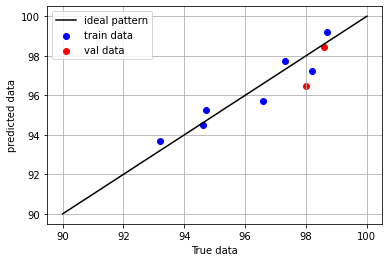

In [7]:
import matplotlib.pyplot as plt
y_predicted_t = [value(model.a)+ value(model.b)*model.xs[i,1]+value(model.c)*model.xs[i,2]+value(model.d)*(model.xs[i,1]*model.xs[i,2]) for i in model.s]
y_predicted_v = [value(model.a)+ value(model.b)*model.xv[i,1]+value(model.c)*model.xv[i,2]+value(model.d)*(model.xv[i,1]*model.xv[i,2]) for i in model.v]
yact = [93.2, 94.7, 97.3, 98.7, 96.6, 98.2, 94.6] 
yv = [98.6, 98.0]

fig, ax = plt.subplots(figsize=(6,4)) 
plt.scatter(yact,y_predicted_t, color = 'b', label = "train data")
plt.scatter(yv,y_predicted_v, color = 'r', label = "val data")

plt.plot([90,100],[90,100],'k', label = "ideal pattern")
plt.xlabel('True data')
plt.ylabel('predicted data')
plt.legend(loc="best")
plt.grid(True)

### Step 5: Optimize surrogate

This is the easy step.

**We have a function --> use pyomo, or sci.optimize and OPTIMIZE it!**
<br>
**AS ALWAYS, know what your function is. Does it have nonconvex terms?**

 - If yes, know what solver you used to optimize it, and know if you actually found the globally or locally optimal point of your function.
 
 - If no, there are a lot of solvers that will guarantee global optimality, and at least you know you found the global optimum of that function.


### Step 6: Decide what to do next?

**What to do next???**

First thing to **ALWAYS** do:

 1. The optimum of the surrogate is not the real optimum of your problem. <br> So, take the $x_{surr_{opt}}$ you found, and go back to your *simulation, model, black-box function, experiment* and simulate it to get the $f(x_{surr_{opt}})$.
 
 2. Compare error between $f(x_{surr_{opt}})$ and $f_surr(x_{surr_{opt}})$. <br> If that is very small, then you are in good shape. You could potentially stop searching (if all of your cross-validation errors were very low too).
 
 3. But that rarely happens. If that distance is not small, what to do next???
 

**This is where all of the innovation comes in!**
Adaptive Sampling is one idea. But how do you adaptively sample??

<img src="lecture18_3.png" width="1000" />

# Surrogate Models

**Definitions:** 
 - A surrogate model is a parametric function, that is fitted based on input-output data to approximate the trends in the data.
 - It is a "map" between a set of inputs and an output.
 - A surrogate model is also called a "metamodel".

## Types of surrogate models:

### 1. Regression surrogate models:
When using regression surrogate models, the optimal surrogate function has parameters that: <br> 
**minimize error between surrogate predictions and data**, but function has **less parameters than of data points**. <br>
As a result, the function is not guaranteed to be a perfect fit to all of the collected data. 


In [6]:
from pyomo.environ import *
model = ConcreteModel()

#Define Data:
model.n = [1,2] #dimension (x1: adsorption time, x2: desorption time)
model.s = [1,2,3,4,5,6,7,8,9] #samples
model.yact = {1:93.2, 2:94.7, 3:97.3, 4:98.7, 5:96.6, 6:98.2, 7:94.6, 8:98.6, 9:98.0} 
model.xs = {(1,1):25,(1,2):25,
            (2,1):250,(2,2):25,
            (3,1):25,(3,2):250,
            (4,1):250,(4,2):250,
            (5,1):25,(5,2):138,
            (6,1):250,(6,2):138,
            (7,1):138,(7,2):25,
            (8,1):138,(8,2):250,
            (9,1):138,(9,2):138} 


model.ypred = Var(model.s, within=NonNegativeReals) 
model.a0 = Var()
model.a1 = Var()
model.a2 = Var()
model.a11 = Var()
model.a22 = Var()
model.a12 = Var()

def con_rule(model,i): # postulated function is: y=a0 + a1*x_1 + a2*x_2 + a11*x_1**2 + a22*x_2**2 + a12*x_1*x_2
    return (model.a0+ model.a1*model.xs[i,1]+model.a2*model.xs[i,2]+model.a11*model.xs[i,1]**2 + model.a22*model.xs[i,2]**2 +
            model.a12*(model.xs[i,1]*model.xs[i,2])) - model.ypred[i] == 0
model.con = Constraint(model.s, rule=con_rule) #Instead of defining the constraint as we did above, we now set it equal to the rule.

def obj_rule(model): 
    return sum((model.ypred[i]-model.yact[i])**2 for i in model.s)
model.obj = Objective(rule=obj_rule) #Instead of defining the objective as we did above, we now set it equal to the rule.

#same as above:
solver = SolverFactory('ipopt')
solver.solve(model)
model.a0.pprint()
model.a1.pprint()
model.a2.pprint()
model.a11.pprint()
model.a22.pprint()
model.a12.pprint()

def surr(x1,x2):
    return model.a0 + model.a1*x1 + model.a2*x2 + model.a11*x1**2 + model.a22*x2**2 + model.a12*x1*x2

err = value(sum((model.yact[i]-model.ypred[i])**2 for i in model.s))

print(err)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


a0 : Size=1, Index=None
    Key  : Lower : Value             : Upper : Fixed : Stale : Domain
    None :  None : 91.56090866302713 :  None : False : False :  Reals
a1 : Size=1, Index=None
    Key  : Lower : Value                : Upper : Fixed : Stale : Domain
    None :  None : 0.020264804339473075 :  None : False : False :  Reals
a2 : Size=1, Index=None
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
    None :  None : 0.04878479778423757 :  None : False : False :  Reals
a11 : Size=1, Index=None
    Key  : Lower : Value                  : Upper : Fixed : Stale : Domain
    None :  None : -4.846186262114138e-05 :  None : False : False :  Reals
a22 : Size=1, Index=None
    Key  : Lower : Value                   : Upper : Fixed : Stale : Domain
    None :  None : -0.00011122816875026241 :  None : False : False :  Reals
a12 : Size=1, Index=None
    Key  : Lower : Value                   : Upper : Fixed : Stale : Domain
    None :  None : -1.9694342759875346e-06 : 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


### 2. Interpolating Surrogate Models:
When a function *interpolates* the data, this means that the **Sum of Squared Errors** <br> 
between data and surrogate prediction is **ZERO**. Or else, the function predicts each point exactly. <br> 
This can happen when:
 1. The function we selected to fit has as many parameters as the number of data points. <br> (i.e., fitting a linear model in $n$ dimensions with $n+1$ points.)
 2. Some Machine Learning functions (i.e., Gaussian Processes, Radial Basis Functions) are by default interpolating in nature.


In [7]:
from pyomo.environ import *
model = ConcreteModel()

#Define Data:
model.n = [1,2] #dimension
model.s = [1,2,3,4,5,6] #sample
model.yact = {1:93.2, 2:94.7, 3:97.3, 4:98.7, 5:98.6, 6:98.0} 
model.xs = {(1,1):25, (1,2):25,
            (2,1):250,(2,2):25,
            (3,1):25,(3,2):250,
            (4,1):250,(4,2):250,
            (5,1):138,(5,2):250,
            (6,1):138,(6,2):138} 

model.ypred = Var(model.s, within=NonNegativeReals) 
model.a0 = Var()
model.a1 = Var()
model.a2 = Var()
model.a11 = Var()
model.a22 = Var()
model.a12 = Var()

def con_rule(model,i): # postulated function is: y=a0 + a1*x_1 + a2*x_2 + a11*x_1**2 + a22*x_2**2 + a12*x_1*x_2
    return (model.a0+ model.a1*model.xs[i,1]+model.a2*model.xs[i,2]+model.a11*model.xs[i,1]**2 + model.a22*model.xs[i,2]**2 +
            model.a12*(model.xs[i,1]*model.xs[i,2])) - model.ypred[i] == 0
model.con = Constraint(model.s, rule=con_rule) #Instead of defining the constraint as we did above, we now set it equal to the rule.

def obj_rule(model): 
    return sum((model.ypred[i]-model.yact[i])**2 for i in model.s)
model.obj = Objective(rule=obj_rule) #Instead of defining the objective as we did above, we now set it equal to the rule.

#same as above:
solver = SolverFactory('ipopt')
solver.solve(model)
model.a0.pprint()
model.a1.pprint()
model.a2.pprint()
model.a11.pprint()
model.a22.pprint()
model.a12.pprint()

def surr(x1,x2):
    return model.a0 + model.a1*x1 + model.a2*x2 + model.a11*x1**2 + model.a22*x2**2 + model.a12*x1*x2

err = value(sum((model.yact[i]-model.ypred[i])**2 for i in model.s))

print(err)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


a0 : Size=1, Index=None
    Key  : Lower : Value            : Upper : Fixed : Stale : Domain
    None :  None : 91.5825589970771 :  None : False : False :  Reals
a1 : Size=1, Index=None
    Key  : Lower : Value                : Upper : Fixed : Stale : Domain
    None :  None : 0.019685743159926574 :  None : False : False :  Reals
a2 : Size=1, Index=None
    Key  : Lower : Value                : Upper : Fixed : Stale : Domain
    None :  None : 0.049037216525403764 :  None : False : False :  Reals
a11 : Size=1, Index=None
    Key  : Lower : Value                : Upper : Fixed : Stale : Domain
    None :  None : -4.7162522826227e-05 :  None : False : False :  Reals
a22 : Size=1, Index=None
    Key  : Lower : Value                  : Upper : Fixed : Stale : Domain
    None :  None : -0.0001118749512259534 :  None : False : False :  Reals
a12 : Size=1, Index=None
    Key  : Lower : Value                   : Upper : Fixed : Stale : Domain
    None :  None : -1.9753086419740026e-06 :  None 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


## Discussion:

Are the following statements **TRUE** or **FALSE**?

 1. Since the sum of squared errors (SSE) of interpolating functions is always zero, interpolation is always better than regression. <br>
 *Discussion*: FALSE! <br>
 2. Since SSE when fitting interpolation models is 0, I do not need to validate further. <br>
 *Discussion*: VERY FALSE! <br>
 3. A low SSE for regression, is all I need to assess whether a model is a good fit or not. <br>
 *Discussion*: FALSE, we should do cross validation. Special cases, maybe not (see below). <br>
 4. For regression, I could get away with not doing cross-validation, but for interpolation I need to do cross-validation. <br>
 *Discussion*: True if we have a lot of data and few parameters in regression. Usually, we should cross-validate for both cases. <br>
 

## Scaling

Now consider the regression model we fit earlier, with 9 points and 6 parameters. Let's look at the optimal parameters: <br>
 - a0 : 91.56090866302713 <br>
 - a1 : 0.02026480433947306 <br>
 - a2 : 0.04878479778423757 <br>
 - a11 : -4.846186262114135e-05 <br>
 - a22 : -0.00011122816875026241 <br>
 - a12 : -1.9694342759875084e-06 <br>

**Discussion: True of False?** <br>

 1. Since a11 and a12 are very small, I can just remove them and re-fit the model with 4 parameters and it won't make a difference. <br>

In [8]:
# Calculations to check whether the above statement is true or false:

print(value(model.a11)*250*250)

-2.9476576766391878


In order to make the values of the parameters more interpretable, and to avoid any numerical issues, it is always best to scale data before fitting surrogate models.<br>

### Scaling between 0-1:
For this type of scaling, all we need are the bounds of the data set.

$x_{scaled} = (x-x^{min})/(x^{max}-x^{min}) $ <br>

**Discussion:**
 1. Do we scale both input and output? <br> --> YES
 
 2. What scaling parameters do we use for each input and output? <br>  --> each column of data normalized by different scaling factors
  

In [9]:
## Refit Regression model, after having scaled all data between 0-1
from pyomo.environ import *
model = ConcreteModel()

#Define Data:
model.n = [1,2] #dimension (x1: adsorption time, x2: desorption time)
model.s = [1,2,3,4,5,6,7,8,9] #samples
model.yact = {1:93.2, 2:94.7, 3:97.3, 4:98.7, 5:96.6, 6:98.2, 7:94.6, 8:98.6, 9:98.0} 

# Find max/min of output:
ymax= model.yact[max(model.yact.keys(), key=(lambda k:model.yact[k]))]
ymin= model.yact[min(model.yact.keys(), key=(lambda k:model.yact[k]))]

#Scale dictionary values:
for k in model.yact.keys():
    model.yact[k] = (model.yact[k] - ymin)/(ymax-ymin)
print(model.yact)


model.xs = {(1,1):25,(1,2):25,
            (2,1):250,(2,2):25,
            (3,1):25,(3,2):250,
            (4,1):250,(4,2):250,
            (5,1):25,(5,2):138,
            (6,1):250,(6,2):138,
            (7,1):138,(7,2):25,
            (8,1):138,(8,2):250,
            (9,1):138,(9,2):138} 

# x min-max values:
xmin = 25
xmax = 250

#SCALE model.xs:
for k in model.xs.keys():
    model.xs[k] = (model.xs[k] - xmin)/(xmax-xmin)

model.ypred = Var(model.s, within=NonNegativeReals) 
model.a0 = Var()
model.a1 = Var()
model.a2 = Var()
model.a11 = Var()
model.a22 = Var()
model.a12 = Var()

def con_rule(model,i): # postulated function is: y=a0 + a1*x_1 + a2*x_2 + a11*x_1**2 + a22*x_2**2 + a12*x_1*x_2
    return (model.a0+ model.a1*model.xs[i,1]+model.a2*model.xs[i,2]+model.a11*model.xs[i,1]**2 + model.a22*model.xs[i,2]**2 +
            model.a12*(model.xs[i,1]*model.xs[i,2])) - model.ypred[i] == 0
model.con = Constraint(model.s, rule=con_rule) #Instead of defining the constraint as we did above, we now set it equal to the rule.

def obj_rule(model): 
    return sum((model.ypred[i]-model.yact[i])**2 for i in model.s)
model.obj = Objective(rule=obj_rule) #Instead of defining the objective as we did above, we now set it equal to the rule.

#same as above:
solver = SolverFactory('ipopt')
solver.solve(model)
model.a0.pprint()
model.a1.pprint()
model.a2.pprint()
model.a11.pprint()
model.a22.pprint()
model.a12.pprint()

def surr(x1,x2):
    return model.a0 + model.a1*x1 + model.a2*x2 + model.a11*x1**2 + model.a22*x2**2 + model.a12*x1*x2

err = value(sum((model.yact[i]-model.ypred[i])**2 for i in model.s))

print(err)

{1: 0.0, 2: 0.2727272727272727, 3: 0.7454545454545444, 4: 1.0, 5: 0.6181818181818166, 6: 0.9090909090909091, 7: 0.254545454545453, 8: 0.9818181818181803, 9: 0.8727272727272722}


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


a0 : Size=1, Index=None
    Key  : Lower : Value                 : Upper : Fixed : Stale : Domain
    None :  None : 7.244154693399705e-07 :  None : False : False :  Reals
a1 : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 0.7231815273853804 :  None : False : False :  Reals
a2 : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 1.7615228971595593 :  None : False : False :  Reals
a11 : Size=1, Index=None
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
    None :  None : -0.4439920934919642 :  None : False : False :  Reals
a22 : Size=1, Index=None
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
    None :  None : -1.0217274055593584 :  None : False : False :  Reals
a12 : Size=1, Index=None
    Key  : Lower : Value                 : Upper : Fixed : Stale : Domain
    None :  None : -0.014988674012013935 :  None : False : 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


**DID YOUR CONCLUSIONS CHANGE???** YES - Now relative order of parameters is different!!!

### Scaling data with mean and sd 
Another way to scale is by normalizing the data to have zero mean and unit variance (**Z-Score** or **Standard-Score**). <br>

In this case, we transform the data as follows: <br>

$ \mu = average(x) $ <br>

$ sd  = stdev(x) $ <br>

$x_{scaled} = (x-\mu)/sd $ <br>

**To do at home as follow up: Normalize data for same example with the Z-score method, recalculate the values. Did you get different conclusions?**

**Discussion:Which normalization method is better?**
 1. **Depends on:** <br>
     a. Data amount and Data distribution (Z-score works well when lots of data and normal distribution is good assumption) <br> 
     b. What we want to do with data after normalization (i.e., heuristics that NN work best with 0-1)<br>
 2. **With 0-1 normalization:** does not need to be 0-1. You can perturb between 0.1 - 1.1 or 1-2 if you want to avoid 0 values. <br> 

## Is more data, more parameters always better?

**VERY IMPORTANT TO KNOW ANSWER TO THIS! WHY?**
   - Experiments are costly. Think of you telling your boss to perform many more experiments that cost thousands dollars and time, and then producing the same quality model, or an even worse model !!! <br> 
   
Intuitively, we would all think that as we add more data to our sampling set, and we add more parameters to our surrogates, the fit is going to improve. <br> 

**Is this true???** <br>

**It depends on:** <br>
 1. Where I collect the data
 2. What type of function I use to fit the data
 
**Example: Your black-box function is:** <br>

$f(x) = \frac{1}{(1+25x^2)} $. <br>

$ -1 \le x \le 1 $ <br>

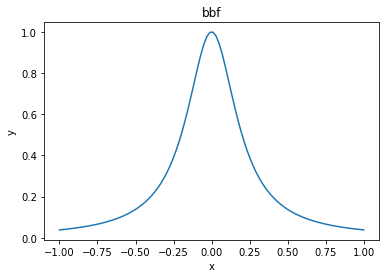

In [10]:
%matplotlib inline
from pylab import *

def bbf(x):
    return 1/(1+25*x**2)

xp = linspace(-1, 1, 100)
yp = bbf(xp)

figure()
plot(xp, yp)
xlabel('x')
ylabel('y')
title('bbf')
show()

Now assume we collected three points, and we fit a quadratic model.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


a0 : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 1.0000000012537877 :  None : False : False :  Reals
a1 : Size=1, Index=None
    Key  : Lower : Value                : Upper : Fixed : Stale : Domain
    None :  None : 7.65645044786951e-18 :  None : False : False :  Reals
a2 : Size=1, Index=None
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
    None :  None : -0.9615384037802706 :  None : False : False :  Reals
0.038461597473517184
1.0000000012537877
0.038461597473517184
{1: 0.038461538461538464, 2: 1.0, 3: 0.038461538461538464}


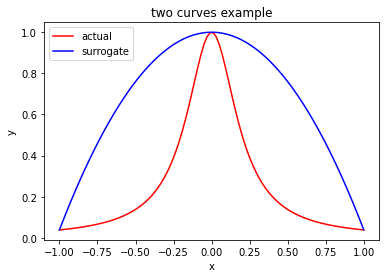

In [11]:
### 3 points, 3 parameters (interpolation of a quadratic function):

xs = array([-1, 0, 1])
ys = bbf(xs)

##WE CAN NUMERICALLY CALCULATE THIS, but let's use Pyomo:
from pyomo.environ import *
model = ConcreteModel()

#Define Data:
model.s = [1,2,3] #samples
model.xs = {1:xs[0], 2:xs[1], 3:xs[2]} 
model.yact = {1:bbf(xs[0]), 2:bbf(xs[1]), 3:bbf(xs[2])}


model.ypred = Var(model.s, within=NonNegativeReals) 
model.a0 = Var()
model.a1 = Var()
model.a2 = Var()

def con_rule(model,i): 
    return (model.a0+ model.a1*model.xs[i]+model.a2*model.xs[i]**2) - model.ypred[i] == 0
model.con = Constraint(model.s, rule=con_rule) #Instead of defining the constraint as we did above, we now set it equal to the rule.

def obj_rule(model): 
    return sum((model.ypred[i]-model.yact[i])**2 for i in model.s)
model.obj = Objective(rule=obj_rule) #Instead of defining the objective as we did above, we now set it equal to the rule.

#same as above:
solver = SolverFactory('ipopt')
solver.solve(model)
model.a0.pprint()
model.a1.pprint()
model.a2.pprint()

def surr(x):
    return value(model.a0) + value(model.a1)*x + value(model.a2)*x**2

print(surr(-1))
print(surr(0))
print(surr(1))

print(model.yact)


y2 = surr(xp)
fig, ax = subplots()

ax.plot(xp, yp, 'r',label="actual")
ax.plot(xp, y2, 'b',label="surrogate")
ax.legend(loc=2); # show legend in upper left corner
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('two curves example');
show()

**Now, add two more points at:**<br> 
x = -0.5
x = 0.5

**Add two more terms to the function: ** <br>

$x^3$   and $x^4$

Recalculate parameters, and plot against actual. Did the function improve?

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


a0 : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 0.5679513167267979 :  None : False : False :  Reals
a1 : Size=1, Index=None
    Key  : Lower : Value                 : Upper : Fixed : Stale : Domain
    None :  None : 4.738434737724204e-17 :  None : False : False :  Reals
a2 : Size=1, Index=None
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
    None :  None : -0.5679512892656475 :  None : False : False :  Reals
2.7461150353680353e-08
0.5679513167267979
2.7461150353680353e-08
{1: 0.038461538461538464, 2: 0.13793103448275862, 3: 1.0, 4: 0.13793103448275862, 5: 0.038461538461538464}


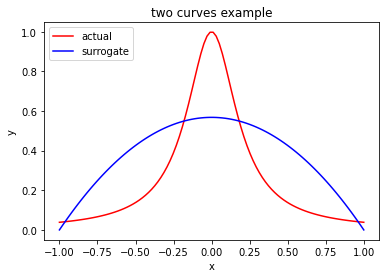

In [12]:
### 5 points, 3 parameters (regression of a quadratic function):

xs = array([-1, -0.5, 0, 0.5, 1])
ys = bbf(xs)

##WE CAN NUMERICALLY CALCULATE THIS, but let's use Pyomo:
from pyomo.environ import *
model = ConcreteModel()

#Define Data:
model.s = [1,2,3,4,5] #samples
model.xs = {1:xs[0], 2:xs[1], 3:xs[2], 4:xs[3], 5:xs[4]} 
model.yact = {1:bbf(xs[0]), 2:bbf(xs[1]), 3:bbf(xs[2]), 4:bbf(xs[3]), 5:bbf(xs[4])}

model.ypred = Var(model.s, within=NonNegativeReals) 
model.a0 = Var()
model.a1 = Var()
model.a2 = Var()

def con_rule(model,i): 
    return (model.a0+ model.a1*model.xs[i]+model.a2*model.xs[i]**2) - model.ypred[i] == 0
model.con = Constraint(model.s, rule=con_rule) #Instead of defining the constraint as we did above, we now set it equal to the rule.

def obj_rule(model): 
    return sum((model.ypred[i]-model.yact[i])**2 for i in model.s)
model.obj = Objective(rule=obj_rule) #Instead of defining the objective as we did above, we now set it equal to the rule.

#same as above:
solver = SolverFactory('ipopt')
solver.solve(model)
model.a0.pprint()
model.a1.pprint()
model.a2.pprint()

def surr(x):
    return value(model.a0) + value(model.a1)*x + value(model.a2)*x**2

print(surr(-1))
print(surr(0))
print(surr(1))

print(model.yact)


y2 = surr(xp)
fig, ax = subplots()

ax.plot(xp, yp, 'r',label="actual")
ax.plot(xp, y2, 'b',label="surrogate")
ax.legend(loc=2); # show legend in upper left corner
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('two curves example');
show()
#Notice how the data is no longer interpolated!

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


a0 : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 1.0000000012537877 :  None : False : False :  Reals
a1 : Size=1, Index=None
    Key  : Lower : Value                  : Upper : Fixed : Stale : Domain
    None :  None : 1.1751272043265875e-18 :  None : False : False :  Reals
a2 : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : -4.277188304680244 :  None : False : False :  Reals


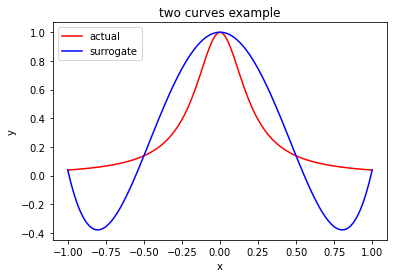

In [13]:
### 5 points, 5 parameters (interpolation of a 4th order polynomial):

xs = array([-1, -0.5, 0, 0.5, 1])
ys = bbf(xs)

##WE CAN NUMERICALLY CALCULATE THIS, but let's use Pyomo:
from pyomo.environ import *
model = ConcreteModel()

#Define Data:
model.s = [1,2,3,4,5] #samples
model.xs = {1:xs[0], 2:xs[1], 3:xs[2], 4:xs[3], 5:xs[4]} 
model.yact = {1:bbf(xs[0]), 2:bbf(xs[1]), 3:bbf(xs[2]), 4:bbf(xs[3]), 5:bbf(xs[4])}

model.ypred = Var(model.s, within=NonNegativeReals) 
model.a0 = Var()
model.a1 = Var()
model.a2 = Var()
model.a3 = Var()
model.a4 = Var()

def con_rule(model,i): 
    return (model.a0+ model.a1*model.xs[i]+model.a2*model.xs[i]**2+model.a3*model.xs[i]**3+model.a4*model.xs[i]**4) - model.ypred[i] == 0
model.con = Constraint(model.s, rule=con_rule) #Instead of defining the constraint as we did above, we now set it equal to the rule.

def obj_rule(model): 
    return sum((model.ypred[i]-model.yact[i])**2 for i in model.s)
model.obj = Objective(rule=obj_rule) #Instead of defining the objective as we did above, we now set it equal to the rule.

#same as above:
solver = SolverFactory('ipopt')
solver.solve(model)
model.a0.pprint()
model.a1.pprint()
model.a2.pprint()

def surr(x):
    return value(model.a0) + value(model.a1)*x + value(model.a2)*x**2 + value(model.a3)*x**3 + value(model.a4)*x**4

y2 = surr(xp)
fig, ax = subplots()

ax.plot(xp, yp, 'r',label="actual")
ax.plot(xp, y2, 'b',label="surrogate")
ax.legend(loc=2); # show legend in upper left corner
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('two curves example');
show()


[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.  ]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


a0 : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 0.6521230598691566 :  None : False : False :  Reals
a1 : Size=1, Index=None
    Key  : Lower : Value                  : Upper : Fixed : Stale : Domain
    None :  None : 3.3084195880594455e-17 :  None : False : False :  Reals
a2 : Size=1, Index=None
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
    None :  None : -1.9023270725809514 :  None : False : False :  Reals


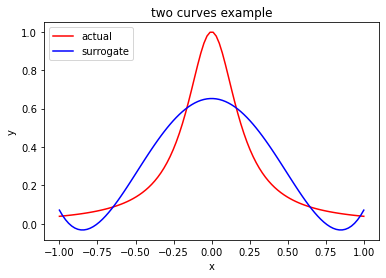

In [14]:
### 9 points, 5 parameters (regression of a 4th order polynomial):
xs = linspace(-1, 1, 9)
ys = bbf(xs)
print(xs)

##WE CAN NUMERICALLY CALCULATE THIS, but let's use Pyomo:
from pyomo.environ import *
model = ConcreteModel()

#Define Data:
model.s = [1,2,3,4,5,6,7,8,9] #samples
model.xs = {1:xs[0], 2:xs[1], 3:xs[2], 4:xs[3], 5:xs[4], 6:xs[5], 7:xs[6], 8:xs[7], 9:xs[8]} 
model.yact = {1:bbf(xs[0]), 2:bbf(xs[1]), 3:bbf(xs[2]), 4:bbf(xs[3]), 5:bbf(xs[4]),
              6:bbf(xs[5]), 7:bbf(xs[6]), 8:bbf(xs[7]), 9:bbf(xs[8])}

model.ypred = Var(model.s, within=NonNegativeReals) 
model.a0 = Var()
model.a1 = Var()
model.a2 = Var()
model.a3 = Var()
model.a4 = Var()

def con_rule(model,i): 
    return (model.a0+ model.a1*model.xs[i]+model.a2*model.xs[i]**2+model.a3*model.xs[i]**3+model.a4*model.xs[i]**4) - model.ypred[i] == 0
model.con = Constraint(model.s, rule=con_rule) #Instead of defining the constraint as we did above, we now set it equal to the rule.

def obj_rule(model): 
    return sum((model.ypred[i]-model.yact[i])**2 for i in model.s)
model.obj = Objective(rule=obj_rule) #Instead of defining the objective as we did above, we now set it equal to the rule.

#same as above:
solver = SolverFactory('ipopt')
solver.solve(model)
model.a0.pprint()
model.a1.pprint()
model.a2.pprint()

def surr(x):
    return value(model.a0) + value(model.a1)*x + value(model.a2)*x**2 + value(model.a3)*x**3 + value(model.a4)*x**4

y2 = surr(xp)
fig, ax = subplots()

ax.plot(xp, yp, 'r',label="actual")
ax.plot(xp, y2, 'b',label="surrogate")
ax.legend(loc=2); # show legend in upper left corner
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('two curves example');
show()

[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.  ]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


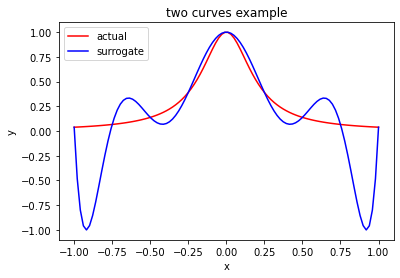

In [15]:
### 9 points, 9 parameters (interpolation of a 8th order polynomial):
xs = linspace(-1, 1, 9)
ys = bbf(xs)
print(xs)

##WE CAN NUMERICALLY CALCULATE THIS, but let's use Pyomo:
from pyomo.environ import *
model = ConcreteModel()

#Define Data:
model.s = [1,2,3,4,5,6,7,8,9] #samples
model.xs = {1:xs[0], 2:xs[1], 3:xs[2], 4:xs[3], 5:xs[4], 6:xs[5], 7:xs[6], 8:xs[7], 9:xs[8]} 
model.yact = {1:bbf(xs[0]), 2:bbf(xs[1]), 3:bbf(xs[2]), 4:bbf(xs[3]), 5:bbf(xs[4]),
              6:bbf(xs[5]), 7:bbf(xs[6]), 8:bbf(xs[7]), 9:bbf(xs[8])}

model.ypred = Var(model.s, within=NonNegativeReals) 
model.a0 = Var()
model.a1 = Var()
model.a2 = Var()
model.a3 = Var()
model.a4 = Var()
model.a5 = Var()
model.a6 = Var()
model.a7 = Var()
model.a8 = Var()

def con_rule(model,i): 
    return (model.a0+ model.a1*model.xs[i]+model.a2*model.xs[i]**2+model.a3*model.xs[i]**3+model.a4*model.xs[i]**4
            + model.a5*model.xs[i]**5 + model.a6*model.xs[i]**6 + model.a7*model.xs[i]**7 + model.a8*model.xs[i]**8) - model.ypred[i] == 0
model.con = Constraint(model.s, rule=con_rule) #Instead of defining the constraint as we did above, we now set it equal to the rule.

def obj_rule(model): 
    return sum((model.ypred[i]-model.yact[i])**2 for i in model.s)
model.obj = Objective(rule=obj_rule) #Instead of defining the objective as we did above, we now set it equal to the rule.

#same as above:
solver = SolverFactory('ipopt')
solver.solve(model)

def surr(x):
    return value(model.a0) + value(model.a1)*x + value(model.a2)*x**2 + value(model.a3)*x**3 + value(model.a4)*x**4 + value(model.a5)*x**5 + value(model.a6)*x**6 + value(model.a7)*x**7 + value(model.a8)*x**8

y2 = surr(xp)
fig, ax = subplots()

ax.plot(xp, yp, 'r',label="actual")
ax.plot(xp, y2, 'b',label="surrogate")
ax.legend(loc=2); # show legend in upper left corner
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('two curves example');
show()

## Intro to regularization

Another **VERY** important topic in surrogate modeling. <br>

**Preliminaries**: <br>
 1. We know that if we can fit a good model with less parameters, that is good. <br>
 2. A model with less parameters/terms, that has a good cross-validation error is very good. <br>
 3. As we add more parameters, do we expect both the training and validation errors to reduce until they basically become zero??? <br>
 
**In-Class Exercise:** While fitting a regression model for a specific problem with fixed dimensionality, draw a plot that has the following characteristics: <br>
1. x-axis: number of terms/parameters of surrogate model (from 0 to N)
2. y-axis: Error

**Draw the trends of two types of errors:** 
 a. The traning error 
 b. The cross-validation error

## Regularization

**Regularization** is a term that refers to penalizing the size of the surrogate model (or else, the number of parameters), while fitting the model. <br>

**WHY?**: Because a model with less parameters that is accurate enough is always going to have the following characteristics: <br>
 - More generalizable <br>
 - More interpretable <br>
 - Potentially easier to optimize <br>
 - Less prone to "over-fitting" <br>
 - A model with less terms, means that an output is dependent on less inputs/features <br>
 
**How do you think you can penalize the number of parameters???** <br>

**IDEAS???**: <br>
 - Idea 1: Constraint on number of parameters sum #par <= A <br>
 - Idea 2: Iterative addition of terms, check Cross - Validation error, stop when increases. <br>
 - Idea 3: <br>



### Generalized linear regression models:

So far, when you hear the term *linear regression model*, you assume the following: <br>

 - Input variables: $x_i$, where $ i = 1,...,n$ <br><br>
 - Surrogate function: $g(x)$ = $ a_0 + \sum_{i=1}^{n}{a_i x_i}$ <br><br>
 
A *generalized linear regression model* (GLM), is defined as: <br><br>

 - Input variables: $x_i$, where $ i = 1,...,n$ <br><br>
 - Input features: $X_j$, where $ j = 1,...,M$ and $X_j = f(x_i)$ <br><br>
 - Surrogate function: $f(X)$ = $ \sum_{j=1}^{M}{b_jX_j}$ <br><br>
 
 
**Example:** <br>
 - Variables: Temperature ($x_1$), Pressure ($x_2$) ($n = 2$) <br><br>
 - Input features: $X_j = \{1, x_1, x_2 , x_1^2, x_2^2, x_1x_2\}$ and ($M = 6$) <br><br>
 - Linear regression model: $g(x) = a_0 + a_1x_1 + a_2x_2 $ <br><br>
 - GLR Surrogate function: $f(X) = b_1 + b_2x_1 + b_3x_2 + b_4x_1^2 +b_5x_2^2 + b_6x_1x_2 $ <br><br>
 
**Discussion:** <br>
 - Observe that GLR is not a linear surrogate function. <br><br>
 - **Why do we call it generalized linear regression???** <br><br>
     - **Answer: The parameter estimation problem (regression) is linear with respect to the parameters. **

### Types of regularization for GLM:

 - We have seen from previous example, that when we use the least-squares error objective and fit a GLM, none of the coefficients become exactly zero. <br><br>
 - Regularization aims to do exactly that. If a term is insignificant --> ensure that it's optimal coefficient is zero! <br><br>

#### L2- Regularization: 

One approach to do this, is through penalizing the sum of squared coefficient values. <br>
That is why this is called *L2-Regularization*, because we are penalizing based on the squared norm of coefficients. <br>

**Typical parameter estimation problem:** <br><br>
$min$  $\sum_{k=1}^{N}{(y^{obs}_{k}-y^{pred}_{k})^2}$ <br><br>
subject to: <br><br>
$y^{pred}_k = \sum_{j=1}^{M}{b_jX^{(k)}_j} $ for $ k = 1,..,N$ <br><br>


**L2-regularization parameter estimation problem:** <br><br>
$min$  $\sum_{k=1}^{N}{(y^{obs}_{k}-y^{pred}_{k})^2} + \sum_{j=1}^{M}{b_j^2} $ <br><br>
subject to: <br><br>
$y^{pred}_k = \sum_{j=1}^{M}{b_jX^{(k)}_j} $ for $ k = 1,..,N$ <br><br>

**Note that the term: $\sum_{j=1}^{M}{b_j^2} $ is also written as the *L2* norm: $||b||^2$ <br><br>


**Let's go back to our adsorption example: Refit the parameters of the quadratic regression function using the L2 penalty term: **

In [16]:
## Refit Regression model, after having scaled all data between 0-1
from pyomo.environ import *
model = ConcreteModel()

#Define Data:
model.n = [1,2] #dimension (x1: adsorption time, x2: desorption time)
model.s = [1,2,3,4,5,6,7,8,9] #samples
model.yact = {1:93.2, 2:94.7, 3:97.3, 4:98.7, 5:96.6, 6:98.2, 7:94.6, 8:98.6, 9:98.0} 

# Find max/min of output:
ymax= model.yact[max(model.yact.keys(), key=(lambda k:model.yact[k]))]
ymin= model.yact[min(model.yact.keys(), key=(lambda k:model.yact[k]))]

#Scale dictionary values:
for k in model.yact.keys():
    model.yact[k] = (model.yact[k] - ymin)/(ymax-ymin)

model.xs = {(1,1):25,(1,2):25,
            (2,1):250,(2,2):25,
            (3,1):25,(3,2):250,
            (4,1):250,(4,2):250,
            (5,1):25,(5,2):138,
            (6,1):250,(6,2):138,
            (7,1):138,(7,2):25,
            (8,1):138,(8,2):250,
            (9,1):138,(9,2):138} 

# x min-max values:
xmin = 25
xmax = 250

#SCALE model.xs:
for k in model.xs.keys():
    model.xs[k] = (model.xs[k] - xmin)/(xmax-xmin)

model.ypred = Var(model.s, within=NonNegativeReals) 
model.a0 = Var()
model.a1 = Var()
model.a2 = Var()
model.a11 = Var()
model.a22 = Var()
model.a12 = Var()

def con_rule(model,i): # postulated function is: y=a0 + a1*x_1 + a2*x_2 + a11*x_1**2 + a22*x_2**2 + a12*x_1*x_2
    return (model.a0+ model.a1*model.xs[i,1]+model.a2*model.xs[i,2]+model.a11*model.xs[i,1]**2 + model.a22*model.xs[i,2]**2 +
            model.a12*(model.xs[i,1]*model.xs[i,2])) - model.ypred[i] == 0
model.con = Constraint(model.s, rule=con_rule) #Instead of defining the constraint as we did above, we now set it equal to the rule.

def obj_rule(model): 
    return sum((model.ypred[i]-model.yact[i])**2 for i in model.s)/9 
model.obj = Objective(rule=obj_rule) #Instead of defining the objective as we did above, we now set it equal to the rule.

#same as above:
solver = SolverFactory('ipopt')
solver.solve(model)
model.a0.pprint()
model.a1.pprint()
model.a2.pprint()
model.a11.pprint()
model.a22.pprint()
model.a12.pprint()

def surr(x1,x2):
    return model.a0 + model.a1*x1 + model.a2*x2 + model.a11*x1**2 + model.a22*x2**2 + model.a12*x1*x2
err = value(sum((model.yact[i]-model.ypred[i])**2 for i in model.s))
print(value(model.a0**2 + model.a1**2 + model.a2**2 + model.a11**2 + model.a22**2 + model.a12**2))
print(err)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


a0 : Size=1, Index=None
    Key  : Lower : Value                 : Upper : Fixed : Stale : Domain
    None :  None : 6.394118234897181e-06 :  None : False : False :  Reals
a1 : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 0.7231710640042278 :  None : False : False :  Reals
a2 : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 1.7615123648873634 :  None : False : False :  Reals
a11 : Size=1, Index=None
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
    None :  None : -0.4439874621123979 :  None : False : False :  Reals
a22 : Size=1, Index=None
    Key  : Lower : Value             : Upper : Fixed : Stale : Domain
    None :  None : -1.02172272848288 :  None : False : False :  Reals
a12 : Size=1, Index=None
    Key  : Lower : Value                 : Upper : Fixed : Stale : Domain
    None :  None : -0.014981678384029397 :  None : False : Fals

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [17]:
## Refit Regression model, after having scaled all data between 0-1
from pyomo.environ import *
model = ConcreteModel()

#Define Data:
model.n = [1,2] #dimension (x1: adsorption time, x2: desorption time)
model.s = [1,2,3,4,5,6,7,8,9] #samples
model.yact = {1:93.2, 2:94.7, 3:97.3, 4:98.7, 5:96.6, 6:98.2, 7:94.6, 8:98.6, 9:98.0} 

# Find max/min of output:
ymax= model.yact[max(model.yact.keys(), key=(lambda k:model.yact[k]))]
ymin= model.yact[min(model.yact.keys(), key=(lambda k:model.yact[k]))]

#Scale dictionary values:
for k in model.yact.keys():
    model.yact[k] = (model.yact[k] - ymin)/(ymax-ymin)

model.xs = {(1,1):25,(1,2):25,
            (2,1):250,(2,2):25,
            (3,1):25,(3,2):250,
            (4,1):250,(4,2):250,
            (5,1):25,(5,2):138,
            (6,1):250,(6,2):138,
            (7,1):138,(7,2):25,
            (8,1):138,(8,2):250,
            (9,1):138,(9,2):138} 

# x min-max values:
xmin = 25
xmax = 250

#SCALE model.xs:
for k in model.xs.keys():
    model.xs[k] = (model.xs[k] - xmin)/(xmax-xmin)

model.ypred = Var(model.s, within=NonNegativeReals) 
model.a0 = Var()
model.a1 = Var()
model.a2 = Var()
model.a11 = Var()
model.a22 = Var()
model.a12 = Var()

def con_rule(model,i): # postulated function is: y=a0 + a1*x_1 + a2*x_2 + a11*x_1**2 + a22*x_2**2 + a12*x_1*x_2
    return (model.a0+ model.a1*model.xs[i,1]+model.a2*model.xs[i,2]+model.a11*model.xs[i,1]**2 + model.a22*model.xs[i,2]**2 +
            model.a12*(model.xs[i,1]*model.xs[i,2])) - model.ypred[i] == 0
model.con = Constraint(model.s, rule=con_rule) #Instead of defining the constraint as we did above, we now set it equal to the rule.

def obj_rule(model): 
    return sum((model.ypred[i]-model.yact[i])**2 for i in model.s)/9 + model.a0**2 + model.a1**2 + model.a2**2 + model.a11**2 + model.a22**2 + model.a12**2
model.obj = Objective(rule=obj_rule) #Instead of defining the objective as we did above, we now set it equal to the rule.

#same as above:
solver = SolverFactory('ipopt')
solver.solve(model)
model.a0.pprint()
model.a1.pprint()
model.a2.pprint()
model.a11.pprint()
model.a22.pprint()
model.a12.pprint()

def surr(x1,x2):
    return model.a0 + model.a1*x1 + model.a2*x2 + model.a11*x1**2 + model.a22*x2**2 + model.a12*x1*x2
err = value(sum((model.yact[i]-model.ypred[i])**2 for i in model.s))
print(err)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


a0 : Size=1, Index=None
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
    None :  None : 0.19268360546824037 :  None : False : False :  Reals
a1 : Size=1, Index=None
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
    None :  None : 0.10424945781441729 :  None : False : False :  Reals
a2 : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 0.1629787739648665 :  None : False : False :  Reals
a11 : Size=1, Index=None
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
    None :  None : 0.08086880713758907 :  None : False : False :  Reals
a22 : Size=1, Index=None
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
    None :  None : 0.13083691996445543 :  None : False : False :  Reals
a12 : Size=1, Index=None
    Key  : Lower : Value               : Upper : Fixed : Stale : Domain
    None :  None : 0.08269758706248612 :  None : False : False 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


**DID IT WORK?** <br><br>
**DID you find a better solution??** <br><br>
**DID any parameters switch to zero?** <br> <br>
**WHY DO YOU THINK THAT IS???** <br> <br>

#### L1- Regularization (LASSO): 

Another popular approach to do this, is through penalizing the sum of absolute coefficient values. <br>
That is why this is called *L1-Regularization*, because we are penalizing based on the absolute values of coefficients. <br>

**Original LASSO formulation:** <br><br>
$min$  $\frac{\sum_{k=1}^{N}{(y^{obs}_{k}-y^{pred}_{k})^2}}{N}  $ <br><br>
subject to: <br><br>
$ \sum_{j=1}^{M}{|b_j|} \le t $ <br><br>
$y^{pred}_k = \sum_{j=1}^{M}{b_jX^{(k)}_j} $ for $ k = 1,..,N$ <br><br>

where $t$ is a free parameter, specified by user to define the degree of regularization. <br><br>

**Note that the term: $\sum_{j=1}^{M}{|b_j|} $ is also written as the *L1* norm: $||b||^1$ <br><br>

**If I reformulate this problem as follows:** <br> <br>
$min$  $\frac{\sum_{k=1}^{N}{(y^{obs}_{k}-(\sum_{j=1}^{M}{b_jX^{(k)}_j}))^2}}{N}  $ <br><br>
subject to: <br><br>
$ \sum_{j=1}^{M}{|b_j|} \le t $ <br><br>

**What is the Largrange function of this constrained optimization problem???** <br><br>


#### Geometric interpretation of the L2 and L1 regularization problems:

<img src="L1_and_L2_balls.svg.png" width="500" />

#### General forms of all types of regularization: 

1. Ridge Regression: $min$ $\{\frac{1}{N}||y-Xb||^2+\lambda||b||^2\}$ <br><br>
2. LASSO Regression: $min$ $\{\frac{1}{N}||y-Xb||^2+\lambda||b||^1\}$ <br><br>


**DISCUSSION:** <br> <br>

**Pros of L1:**<br>
 - Built-in feature selection<br>
**Cons of L1:**<br>
 - Optimization formulation <br>
 - Multiple solutions may exist <br>
 
**Pros of L2:** <br>
 - Optimization formulation: Analyitical solution exists <br>
**Cons of L2:** <br>
 - No guaranteed feature selection <br>
 
 
#### Proposed solution: Elastic Net Regularization

Based on the above pro's and con's of the two methods, a new regularization technique has been proposed that attempts to take advantage of both pros of both methods: 

3. Elastic Net Regression: $min$ $\{\frac{1}{N}||y-Xb||^2+\lambda(\alpha||b||^1+(1-\alpha)||b||^2)\}$ <br><br>

**DISCUSSION:** <br> <br>

#### Geometric interpretations:

1. Ridge vs Lasso:
<img src="RidgevsLasso1.png" width="500" />
<img src="RidgevsLasso2.png" width="500" />

2. Ridge vs Lasso vs Elastic Net:
<img src="RidgevsLassovsEN.png" width="500" />


### Uses of regularization: 

**Used for regression coupled with feature selection:** <br>
 - If you have a data set with many features/inputs, and you are not sure if all of them are important to predict an output you can use these techniques to **not only fit a function**, but also **remove features** at the same time. <br> <br>
  - **Limitations for feature selection using these methods**: 
    - Assumes that features are linearly dependent on an output!!! <br> <br>
    - May not work well if features are dependent with each other (for these problems, we use techniques like Principal Component Analysis). <br> <br>
        
**Example:** Collect 10000 measurements from 50 sensors in my chemical plant (each sensor measuring an operating condition in different units). <br> The output we are interested in is a production level, which must meet a minimum. <br> I am not sure which of the 50 measurements are needed for an operator to monitor, to predict whether the minimum production level will be reached. <br>
 - I have a data set of 10000 rows and (50+1) columns 
 - Use Lasso, or EN to fit a regularized regression model to see whether some must be removed:
 - Input variables: $x_i$, where $ i = 1,...,50$ <br><br>
 - Surrogate function: $g(x)$ = $ a_0 + \sum_{i=1}^{n}{a_i x_i}$ <br><br>

**MORE EXAMPLES AT: http://statweb.stanford.edu/~tibs/ftp/talk-toronto.pdf** <br><br>

**What do we do if we know that the output is nonlinearly correlated to the inputs???** <br><br>
 - Why not build a GLM??<br><br>
 
**Example:** <br>
 - Variables: Temperature ($x_1$), Pressure ($x_2$) ($n = 2$) <br><br>
 - Input features: $X_j = \{1, x_1, x_2 , x_1^2, x_2^2, x_1x_2\}$ and ($M = 6$) <br><br>
 - Linear regression model: $g(x) = a_0 + a_1x_1 + a_2x_2 $ <br><br>
 - GLR Surrogate function: $f(X) = b_1 + b_2x_1 + b_3x_2 + b_4x_1^2 +b_5x_2^2 + b_6x_1x_2 $ <br><br>
 - I can then use LASSO, Elastic net to select out of 6 features.
 
**DISCUSSION:**<br>
 - How do I know what nonlinear features to add???<br><br>
 - Size of problem!!!<br><br>

# Learning with scikit-learn

## Installation:
1. Open your Anaconda Prompts and install two packages by running the following commands: <br>
 - conda install -c conda-forge pydoe <br>
 - conda install scikit-learn <br><br>

**scikit-learn** (scikit-learn.org) is a python package that includes a lot of popular Machine Learning tasks: <br>
- Classification, <br>
- Regression, <br>
- Clustering, <br>
- Dimensionality reduction, <br> 
- Model selection and <br>
- Data-preprocessing <br><br>

We are interested in **Regression**:<br>
**scikit-learn** allows you to do: <br>
- Generalized linear models <br>
- Support Vector regression <br>
- Neural Networks <br>
- Gaussian Process Models <br>
- Many more... <br><br>

**Today we will wrap-up our discussion on these three models and show how to train a simple input-output data set.** <br>

**Data**: First we need a problem. Let's solve an black-box optimization problem.<br>

Let's assume you have to find the global minimum of a problem with 2 variables. <br> <br> 
All you know about the problem is the dimensionality, the bounds and you have a simulation or experiment that will give you values of your objective for specific values of the input variables. <br>

Variable 1 ($x_1$) can range between $-2 \le x_1 \le 2$ and variable 2 ranges between $-1 \le x_2 \le 3$. <br>

## Step 1- Initial Sampling Design:

First you need to decide how many samples you are going to collect, and what design you will use. <br>

Let's say I have made that decision for you. I have collected $10*n+5=25$ points using a Latin Hypercube Design. 

[[-2  2]
 [-1  3]]
[[0.22 0.5 ]
 [0.54 0.54]
 [0.5  0.82]
 [0.74 0.9 ]
 [0.18 0.34]
 [0.7  0.66]
 [0.62 0.94]
 [0.02 0.22]
 [0.3  0.78]
 [0.78 0.42]
 [0.1  0.14]
 [0.14 0.26]
 [0.58 0.62]
 [0.66 0.18]
 [0.42 0.02]
 [0.38 0.1 ]
 [0.06 0.46]
 [0.98 0.58]
 [0.9  0.7 ]
 [0.82 0.98]
 [0.46 0.3 ]
 [0.94 0.38]
 [0.34 0.86]
 [0.26 0.74]
 [0.86 0.06]]


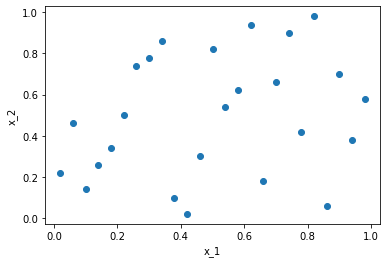

In [18]:
import numpy as np
import scipy as sp
import pyDOE as pd
import matplotlib.pyplot as plt

n = 2 #dimension
N = 10*n+5 #samples
xbounds = np.array([[-2,2],[-1,3]])
print(xbounds)
Xsc = pd.lhs(n, samples=N, criterion='centermaximin')

print(Xsc)

plt.plot(Xsc[:, 0], Xsc[:, 1], 'o')
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.show()

## Step 2- Data Collection:

- First we observe that the LHS design is within 0-1 range in all dimensions. <br>
- We need to 'translate' what that is in the real domain of our problem. <br>
- After that, we collect the data. <br>

[[-1.12  1.  ]
 [ 0.16  1.16]
 [ 0.    2.28]
 [ 0.96  2.6 ]
 [-1.28  0.36]
 [ 0.8   1.64]
 [ 0.48  2.76]
 [-1.92 -0.12]
 [-0.8   2.12]
 [ 1.12  0.68]
 [-1.6  -0.44]
 [-1.44  0.04]
 [ 0.32  1.48]
 [ 0.64 -0.28]
 [-0.32 -0.92]
 [-0.48 -0.6 ]
 [-1.76  0.84]
 [ 1.92  1.32]
 [ 1.6   1.8 ]
 [ 1.28  2.92]
 [-0.16  0.2 ]
 [ 1.76  0.52]
 [-0.64  2.44]
 [-0.96  1.96]
 [ 1.44 -0.76]]


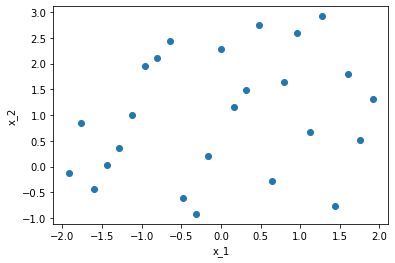

[  10.966336  129.391936  520.84      281.704256  168.629056  100.04
  640.158016 1457.394496  222.28       33.007936  906.76      419.506496
  190.240576   47.684416  106.272576   71.146816  517.293376  560.831296
   58.12      164.328256    4.387136  664.979776  414.942016  111.669056
  803.122496]


In [19]:
Xsc[:,0] = (Xsc[:,0]*(xbounds[0,1]-xbounds[0,0])+xbounds[0,0])
Xsc[:,1] = (Xsc[:,1]*(xbounds[1,1]-xbounds[1,0])+xbounds[1,0])
print(Xsc)
X=Xsc
plt.plot(X[:, 0], X[:, 1], 'o')
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.show()

#Black-box simulation:
def bbs(x):
    return 100.0*(x[:,1]-x[:,0]**2.0)**2.0 + (1-x[:,0])**2.0

Y = bbs(X)
print(Y)

## Step 3- Fit simplest model possible:

**Now that we have our X-Y data, we can start fitting functions.** <br>

Let's first fit a very simple linear regression function: $y_{surr} = a_0 + a_1x_1 + a_2x_2 $ <br>

- We have seen how to do this with Pyomo, as an optimization problem. <br>
- Now let's see the syntax for how we could do that in Python. <br>

Coefficients: 
 311.2091092147788 [ -2.79947443 -24.32113228]
Mean squared error validation: 316060.70
Mean squared error training: 69592.52


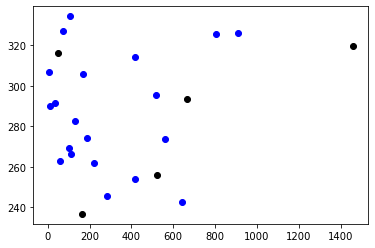

In [20]:
#import the linear model component:
from sklearn import linear_model
import random
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

#create a linear regression object:
reg = linear_model.LinearRegression(fit_intercept=True,normalize=False,copy_X=True)

#create a training and validation set:
N_train = 20 #number of training points
N_val   = 5 # number of validation points

#All samples set:
s = set(range(0,25))
s_train = random.sample(s,N_train) #randomly select 20 points
s_val   = list(set(s)-set(s_train)) # find the difference of sets

X_train = X[s_train]
Y_train = Y[s_train]
X_val  = X[s_val]
Y_val  = Y[s_val]

#fit the model:
reg.fit(X_train,Y_train)

#make predictions using the validation (test) set:
Y_pred = reg.predict(X_val)
Y_pred_train = reg.predict(X_train)

# Print the coefficients
print('Coefficients: \n', reg.intercept_,reg.coef_)

# The mean squared error of validation
print("Mean squared error validation: %.2f"
      % mean_squared_error(Y_val, Y_pred))

# The mean squared error of training
print("Mean squared error training: %.2f"
      % mean_squared_error(Y_train, Y_pred_train))

# Plot outputs
plt.scatter(Y_val, Y_pred,  color='black')
plt.scatter(Y_train, Y_pred_train,  color='blue')

plt.show()

## Step 4 - Assessment: 

- Clearly the linear fit is a really bad fit!
- We need to resort to nonlinear surrogate models.
- We could try generalized linear model.
- What about Gaussian Process Models?

## Step 5 - Try different more complex surrogates:

### Gaussian Process Model:


<img src="Slide1.PNG" width="1000" />

<img src="Slide2.PNG" width="1000" />

<img src="Slide3.PNG" width="1000" />

In [21]:
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn import preprocessing
from sklearn import gaussian_process as gp
from sklearn.gaussian_process.kernels import  RBF
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, validation_curve, learning_curve, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LarsCV, OrthogonalMatchingPursuitCV
from sklearn.svm import SVR

In [22]:
#Kernel
kernel = RBF()
#kernel_list=[Matern(), RBF(), DotProduct()]

# Gaussian Process Parameters
gp_params = {'kernel': kernel,
             'alpha': 1e-10,
             'copy_X_train': True,
             'n_restarts_optimizer':0,
             'normalize_y':False
}

# Initiate the Gaussian process
model = gp.GaussianProcessRegressor(kernel=kernel, normalize_y=True)

model.fit(X_train, Y_train)

#objective function
scoring = 'mean_squared_error'

refit=True

print("Parameters of Estimator:", model.get_params(deep=True))


Parameters of Estimator: {'alpha': 1e-10, 'copy_X_train': True, 'kernel__length_scale': 1.0, 'kernel__length_scale_bounds': (1e-05, 100000.0), 'kernel': RBF(length_scale=1), 'n_restarts_optimizer': 0, 'normalize_y': True, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None}


coefficient of determination R^2 of the prediction: -0.3251059022520162
MSE: 0.0
Standard-Deviation: [265.28187372 265.28187372 265.28187372 265.28187372 265.28187372]


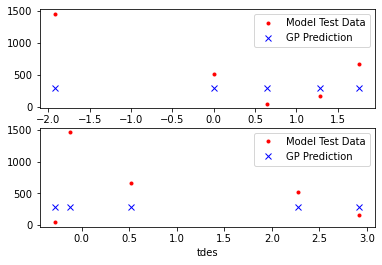

In [23]:
# Predict with test set
Y_pred, sigma = model.predict(X_val, return_std=True)
print("coefficient of determination R^2 of the prediction:", model.score(X_val, Y_val))
print("MSE:", mean_squared_error(Y_val, Y_val), )
print("Standard-Deviation:", sigma)

fig, axes = plt.subplots(2, 1)

axes[0].plot(X_val[:,0], Y_val, 'r.', marker='.', label='Model Test Data')
axes[0].plot(X_val[:,0], Y_pred, 'b.', marker='x', label='GP Prediction')
axes[0].set_xlabel('tads')
axes[0].legend()

axes[1].plot(X_val[:,1], Y_val, 'r.', marker='.', label='Model Test Data')
axes[1].plot(X_val[:,1], Y_pred, 'b.', marker='x', label='GP Prediction')
axes[1].set_xlabel('tdes')
axes[1].legend()

x_line = np.linspace(0,1,100)
y_line = x_line

plt.show()

### Neural Networks in sklearn:

In [24]:
from sklearn.neural_network import MLPRegressor

# We need this so that we search over many parameters that define the NN structure:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)

#create model structure:
model = MLPRegressor(max_iter=5000, validation_fraction = 0.2,tol=1e-2)

#Define the parameters to search over for:
param_grid = {'activation': ['tanh'],
                'solver':['adam'],
                'alpha' : [0.001, 0.01],
                'hidden_layer_sizes':[(i,) for i in np.arange(3,30,5)],
             }

#This grid search will automatically search over parameter values, and try to identify model with best architecture:
grid = GridSearchCV(model, param_grid,  cv = 3, verbose=0)

grid.fit(X, y)

GridSearchCV(cv=3,
             estimator=MLPRegressor(max_iter=5000, tol=0.01,
                                    validation_fraction=0.2),
             param_grid={'activation': ['tanh'], 'alpha': [0.001, 0.01],
                         'hidden_layer_sizes': [(3,), (8,), (13,), (18,), (23,),
                                                (28,)],
                         'solver': ['adam']})

### Support Vector Regression: 

1. Final form of surrogate very similar to Gaussian Process model
2. Final form has less terms, because this model is "Regressing the points"
3. Very clever idea used to select a subset of points to be the points we get weighted output values from (these are our support vectors!)
4. Very good resource: https://alex.smola.org/papers/2004/SmoSch04.pdf
5. Best used when data is noisy!
6. Scikit-learn has this as well: from sklearn.svm import SVR

<img src="Lecture 22_svr.png" width="1000" />